# Text Classification:  Insults with Naive Bayes

In [1]:
import sys;print(sys.version)

3.11.7 (main, Dec 15 2023, 18:12:31) [GCC 11.2.0]


In [1]:
import numpy as np
import pandas as pd
import sklearn
from datetime import datetime
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn.feature_extraction.text as text
import sklearn.naive_bayes as nb
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Load libraries
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.datasets import make_classification
from sklearn.decomposition import NMF, PCA, TruncatedSVD



In the notebook we dive into the general question of feature selection for classifiers. In the regression
and classification module notebook **Dimensionality Reduction** we looked at 
applying dimensionality reduction to classifie4rs; here we turn to feature selection, another
technique that generally results in more compact representations and hopefully better performing
classifiers.

The general form of what we're doing
in this notebook is to use  some metric
to quantify the usefulness of each feature in order to
discard all but the top $k$ features.  We'll look at the following feature selection functions in scikit learn.

$$
\begin{array}[t]{lll}
1. &  \text{mutual_info_classif} &  \text{Mutual information for a discrete target.}\\
2. &  \text{chi2} & \chi^2 \text{ stat for non-negative features for classification tasks.}\\
3. &  \text{fclassif} &  \text{ANOVA F-value between label/feature for classification tasks.}\\
\end{array}
$$

Mutual Information, written $\text{I}$, is defined to be:

$$
\text{I}\,(X;\,Y) = \text{D}_{\text{KL}}\,(\, \text{P}_{X,Y} \mid\mid \text{P}_{X}\otimes \text{P}_{Y}\, )
$$


where $D_{\text{KL}}$ is the Kullback-Leibler Divergence (KL-Divergence) of two distributions and
$\text{P}_{X,Y}$ is the joint distribution of X and Y and $\text{P}_{X}\otimes \text{P}_{Y}$ is 
the distribution that gives $P(X) \times P(Y)$ as the joint probability of X and Y.
KL Divergence is an Information Theoretic measure of the divergence
between two distributions, $\text{I}\,(X;\,Y)$ measures the distance between
the joint distribution and the distribution that would obtain
if X and Y were completely independent.  If X and Y are independent,
$\text{I}\,(X;\,Y)$ is 0.  If X conditionally depends on Y, that
increases the difference between the joint distribution and independence ($\text{P}_{X}\otimes \text{P}_{Y}$).

Thus $\text{I}\,(X;\,Y)$ measures the amount of information you gain about the outcome of $Y$
if you know the outcome $X$.  If Y is a class assignment and X is a feature column
in our data matrix, $\text{I}\,(X;\,Y)$  measures how much knowing the value of feature $X$ 
tells us about the class Y.  Hence, it makes sense to use $\text{I}\,(F;\,c)$ to measure how useful
feature F is for a classification problem.  

The chi2 classification function takes the feature matrix and the class labels  as arguments
and for each feature and each computes the $\Xi^{2}@ statistic representing the strength
of the feature's association with the class.

A note of caution:  The test really only makes sense for categorical variables, but
the scikit learn implementation is built in such a way that it can be used for
continuous variables.  We will try both.

In [4]:
X, y = make_classification(
        n_samples=100, n_features=10, n_informative=2, n_clusters_per_class=1, 
        shuffle=False, random_state=42,shift=5)
chi2_stats, p_values = chi2(X, y)
chi2_stats

array([2.25415508e+01, 7.35179236e-02, 7.25973700e-02, 1.01320229e-02,
       1.08125275e+00, 5.54434465e-02, 1.13279935e-02, 1.09136519e-01,
       1.32228682e-01, 1.66505941e-02])

The numbers show that all but 2 of the 10 features have little connection with the classification
problem.  Of course we set it up this way when we created `X, y` with `make_classification`,  by
setting the parameter `n_informative` to 2.

Here are the column numbers arranged from least significant to most significant:

In [10]:
chi2_stats.argsort()

array([3, 6, 9, 5, 2, 1, 7, 8, 4, 0])

Hence, the following code makes a new feature matrix containing only the two
most significant features (the columns indexed 0 and 4).

In [11]:
X_reduced = X[:, chi2_stats.argsort()[-2:]]

Finally the ANOVA F-value (or `fclassif` in scikit learn) compares the ration of explained
variance to the unexaplined variance. If the null hypothesis is true, you expect F to have a value close to 1.0 most of the time. A large F ratio means that the variation among group means is more than you'd expect to see by chance.

## Loading the data

Let's open the CSV file with `pandas`.

In [2]:
import os.path
site = 'https://raw.githubusercontent.com/gawron/python-for-social-science/master/'\
'text_classification/'
#site = 'https://gawron.sdsu.edu/python_for_ss/course_core/book_draft/_static/'
df = pd.read_csv(os.path.join(site,"troll.csv"))

Each row is a comment  taken from a blog or online forum. There are three columns: whether the comment is insulting (1) or not (0), the data, and the unicode-encoded contents of the comment.

In [3]:
df[['Insult', 'Comment']].tail()

,Insult,Comment
3942,1,"""you are both morons and that is never happening"""
3943,0,"""Many toolbars include spell check, like Yahoo..."
3944,0,"""@LambeauOrWrigley\xa0\xa0@K.Moss\xa0\nSioux F..."
3945,0,"""How about Felix? He is sure turning into one ..."
3946,0,"""You're all upset, defending this hipster band..."


In [4]:
# Split the data into training and test sets FIRST
T_train,T_test, y_train,y_test = train_test_split(df['Comment'],df['Insult'])

### Demoing $\chi^{2}$

We imported the `chi2` function:

In [5]:
chi2

<function sklearn.feature_selection._univariate_selection.chi2(X, y)>

Here's ine way to use it:

In [9]:
X_train.toarray()[0,:].max()

0.5193816927044406

In [10]:
#tf = text.TfidfVectorizer(min_df=2,max_df=.8)
sublinear_tf = True
#subliner_tf = False
tf = text.TfidfVectorizer(sublinear_tf=sublinear_tf)
# Train your vectorizer oNLY on the trainingh data.
X_train = tf.fit_transform(T_train)
print(*X_train.shape)
# N features with highest chi-squared statistics are selected
# chi2 is a functiomported above
chi2_features = SelectKBest(chi2, k = 10_000)
X_train_chi = chi2_features.fit_transform(X_train, y_train)

2960 14053


`X-train` is our **term-document** matrix.

In [11]:
X_train.shape,X_train_chi.shape

((2960, 14053), (2960, 10000))

## Preliminary experiments

Now, we are going to train a classifier as usual. We
have already split the data and labels into train and test sets.

We use an **SVM classifier** and try it out on the two representations of our
data,.

In [12]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
clf_chi = LinearSVC()

# Unreduced
clf.fit(X_train, y_train)

LinearSVC()

In [13]:
# Reduced
clf_chi.fit(X_train_chi, y_train)

LinearSVC()

And we're done.  How'd we do?  Now we  test on the test set.  Before we can do that we need to
vectorize the test set.  But don't just copy what we did with the training data:

```
X_test = tf.fit_transform(T_test)
```

That would retrain the vectorizer from scratch.  Any words that occurred in the training texts
but not in the test texts would be forgotten!  Plus training the vectorizer
is part of the classifier training pipeline.  If we let the vectorizer see
the test data during its training phase, we'd be compromising the whole
idea of splitting training and test data.  So what we want to do
with the test data is just apply the transform part of vectorizing:

```
X_test = tf.transform(T_test)
```

That is, build a representation of the test data using only the vocabulary you learned
about in training.  Ignore any new words.

In [14]:
X_test = tf.transform(T_test)
X_test_chi = chi2_features.transform(X_test)
clf.score(X_test, y_test),clf_chi.score(X_test_chi, y_test)

(0.8267477203647416, 0.8358662613981763)

### Idea one:  Use a pipeline

Well, not a reliable result.  But at least trimming down the model didn't seem to hurt it.

Let's clean this all up a bit by putting everything in a pipeline.

In [70]:
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

#from sklearn import decomposition as dec
#from pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler

#poly = preprocessing.PolynomialFeatures(degree=20, include_bias=True)
#scaler = preprocessing.StandardScaler()
#lin_reg2 = linear_model.LinearRegression()

X,y = df['Comment'].values,df['Insult'].values

def make_tfidf_feat_selection_clf_pipeline (selection_function=None, k=5_000,
                                         selector = SelectKBest,sublinear_tf=False):
    tf = text.TfidfVectorizer(sublinear_tf=sublinear_tf)
    #chi2_features = SelectKBest(selector, k)
    if selection_function is not None:
        k_best_features = selector(selection_function, k=k)
    else:
        k_best_features = selector(k=k)
    svm_clf = LinearSVC()
    return pipeline.Pipeline([('vect', tf), ('feat_selector', k_best_features), ('svm', svm_clf)])


pipeline_reg = make_tfidf_feat_selection_clf_pipeline (selection_function=f_classif, k=5_000,sublinear_tf=True)

# Train
T_train,T_test, y_train,y_test = train_test_split(X,y)
pipeline_reg.fit(T_train, y_train)
predicted = pipeline_reg.predict(T_test)

accuracy_score(predicted, y_test),\
precision_score(predicted, y_test),\
recall_score(predicted, y_test)

(0.8389057750759878, 0.5490909090909091, 0.8118279569892473)

### Idea 2:  Evaluate over multiple train text splits; report means



In [71]:
def print_stats(stats_means):
    """
    means is an i x j x 3 array.
    i: number of selection fns
    j: number of dimension values
    """
    for (i,fn) in enumerate(selection_functions):
        fstring = fn.__name__
        print(f"{fstring:<8}   a      p     r",end="\n" + "="*31 + "\n")
        fn_scores = stats_mean[i]
        for (j,k) in enumerate(dimension_vals):
            a,p,r = fn_scores[j]
            print(f" {k:>6_d} | {a:.3f} {p:.3f} {r:.3f}")
        print()

num_splits = 10

selection_functions = [f_classif, chi2]
dimension_vals = (3_000, 5_000, 10_000)
#accuracy, precision, recall
num_metrics = 3
# a 10x2x3x3 array (=120 fits)
stats = np.zeros((num_splits, len(selection_functions), len(dimension_vals), num_metrics))
sublinear_tf=True
X,y = df['Comment'].values,df['Insult'].values

for test_run in range(num_splits):
    # Each candidate system in theinner loops runs on the same train/test split
    T_train, T_test, y_train,y_test = train_test_split(X,y)
    scores = stats[test_run]
    for (j, selection_function) in enumerate(selection_functions):
        print(f"Split {test_run}: {selection_function.__name__}",)#end="\n===================\n")
        j_scores = scores[j]
        for (i,k) in enumerate(dimension_vals):
            pipeline_reg = make_tfidf_feat_selection_clf_pipeline (selection_function = selection_function,k=k,
                                                               sublinear_tf=sublinear_tf)
        
            # Train
            pipeline_reg.fit(T_train, y_train)
            # Test
            predicted = pipeline_reg.predict(T_test)
            j_scores[i] = accuracy_score(predicted, y_test),\
                                    precision_score(predicted, y_test),\
                                     recall_score(predicted, y_test)
    print()

stats_means = stats.mean(axis=0)
print_stats(stats_means)

Split 0: f_classif
Split 0: chi2

Split 1: f_classif
Split 1: chi2

Split 2: f_classif
Split 2: chi2

Split 3: f_classif
Split 3: chi2

Split 4: f_classif
Split 4: chi2

Split 5: f_classif
Split 5: chi2

Split 6: f_classif
Split 6: chi2

Split 7: f_classif
Split 7: chi2

Split 8: f_classif
Split 8: chi2

Split 9: f_classif
Split 9: chi2

f_classif   a      p     r
  3_000 | 0.836 0.553 0.766
  5_000 | 0.838 0.566 0.764
 10_000 | 0.836 0.585 0.745

chi2       a      p     r
  3_000 | 0.838 0.559 0.769
  5_000 | 0.838 0.578 0.757
 10_000 | 0.835 0.592 0.738



The winner is?  Mostly chi2, although note if you go for the highest precision value (.592)m
you end up with a lower recall value then if you did the same with chi2.

#### Poking around our 4d score array

Results from the first of 10 splits (a 2x3x3 array):
3 scores for each of  6 candidate.

In [33]:
#stats.shape is (10, 2, 3, 3)
# 1 of 10 splits a 2x3x3 array (3 scores for each of  6 candidates)
test0 = stats[0]
test0

array([[[0.82674772, 0.51601423, 0.80555556],
        [0.83181358, 0.54092527, 0.8042328 ],
        [0.82877406, 0.5658363 , 0.77184466]],

       [[0.82877406, 0.52313167, 0.80769231],
        [0.83383992, 0.56227758, 0.79396985],
        [0.83282675, 0.57651246, 0.77884615]]])

The chi2 scores for the first split: 3 scores each of 3 candidates.

In [60]:
stats[0][0]

array([[0.83080041, 0.53584906, 0.76344086],
       [0.83282675, 0.5509434 , 0.76041667],
       [0.83383992, 0.58113208, 0.74396135]])

In [65]:
# Take the means across the 10 splits
stats_means = stats.mean(axis=0)
#stats_means.shape (3,2,3)  18 means (3 scores for each of 6 systems)
stats_means

array([[[0.83282675, 0.54345891, 0.76623743],
        [0.83505572, 0.55936573, 0.76309436],
        [0.83444782, 0.58042296, 0.74624624]],

       [[0.83485309, 0.55161653, 0.76786067],
        [0.8337386 , 0.5653802 , 0.75364553],
        [0.83454914, 0.59130789, 0.73986455]]])

In [66]:
# stats_mean[0,0,:]  is selection_function=f_classif,k=3000,  apr scores
stats_means[0,0,:]

array([0.83282675, 0.54345891, 0.76623743])

In [67]:
# stats_mean[1,2,:]  is selection_function=chi2, k=10_000, apr scores 
stats_means[1,2,:]

array([0.83454914, 0.59130789, 0.73986455])

In [56]:
# This is defined and called above

def print_stats(means):
    """
    means is an i x j x 3 array.
    i: number of selection fns
    j: number of dimension values
    """
    for (i,fn) in enumerate(selection_functions):
        fstring = fn.__name__
        print(f"{fstring:<8}   a      p     r",end="\n" + "="*31 + "\n")
        fn_scores = stats_mean[i]
        for (j,k) in enumerate(dimension_vals):
            a,p,r = fn_scores[j]
            print(f" {k:>6_d} | {a:.3f} {p:.3f} {r:.3f}")
        print()

print_stats(stats_means)

f_classif   a      p     r
  3_000 | 0.836 0.553 0.766
  5_000 | 0.838 0.566 0.764
 10_000 | 0.836 0.585 0.745

chi2       a      p     r
  3_000 | 0.838 0.559 0.769
  5_000 | 0.838 0.578 0.757
 10_000 | 0.835 0.592 0.738



####  Mutrual Information

Mutual information can work like the others but used in the context of select KBest
it requires discrete-valued features, so we need a slightly different pipeline.

We will CountVectorize our doc set to give a term document matrix (TDM) filled with
counts, run mutual information on that to feature reduce, and then classify in
the usual way.  Note we use a TfidfTransformer rather than a TfidfVectorizer.  This
is because the docs have already been vectorized so we need a transformer that
maps from a TDM with counts to a TDM with TFIDF values; TfidfTransformer fits
the bill.

The following code also gives us  a chance to try out chi2 on counts, which
it was always intended for.

In [74]:
def make_count_feat_selection_pipeline (selection_function=None, k=500,
                                       selector = SelectKBest,sublinear_tf=False):

    cv = text.CountVectorizer()
    tf = text.TfidfTransformer(sublinear_tf=sublinear_tf)
    
    if selection_function is None:
        kb = selector(k=k)
    else:
        kb = selector(selection_function,k=k)
    
    svm_clf = LinearSVC()
    
    pipeline_reg=pipeline.Pipeline([('vect', cv), 
                                    ('feat_selector', kb),
                                    ('tfidf',tf), 
                                    ('svm', svm_clf)])
    return pipeline_reg

# Mutual info works  with select Kbest on discretely vectorized data
# You can also try these others with this pipeline as well.
# chi2 and f_classif work better with k>3K
# selection_function = f_classif,k=k
# selection_function = chi2, k=k
k=500
pipeline_reg = make_count_feat_selection_pipeline (selection_function=mutual_info_classif, k=k)

# split
T_train,T_test, y_train,y_test = train_test_split(X,y)
# Train
pipeline_reg.fit(T_train, y_train)
# Test
predicted = pipeline_reg.predict(T_test)

# Evaluate
a,p,r = accuracy_score(y_test,predicted,),\
        precision_score(y_test, predicted),\
            recall_score(y_test, predicted)

# MI k= 3_000 a=0.806 p=0.789 r=0.350
# chi k= 3_000 a=0.806 p=0.789 r=0.350
print(f"{k=:>6_d} {a=:.3f} {p=:.3f} {r=:.3f}")

k=   500 a=0.853 p=0.766 r=0.580


##  A Mutual Information transformer

We've done feature selection two different ways, on term document
matrices representing word counts, created by the CountVectorizer,
and on continuously-valued term document matrices representing
word-in-document TFIDF values.

To systematize this,
let's implement a Mutual Information-Transformer (MI-Xformer), using the scikit learn interface.

Assumption:
The MIT **always** accepts a Term Doc Matrix (= a TDM, a 2D numpy array) and always outputs  a 2D numpy array with fewer columns.

We will use the MI X-former two ways

1.  Pass in a sequence of strings and select a vocab using word counts (operating on a Count Vectorized TDM like we did above)
2.  Operate on a TFIDF-valued TDM to do feature selection.


Model A
----------

To do feature selection on the base of counts, we pass the MI X-former a count vectorizer 
TDM and pass back a truncated TDM.  We then pass that to a TFIDFTransformer.
(which accepts a CountVectorized TDM).


T_Train, T_Test, y_Train, y_Test

vec_pipe = [CountVectorizer =>  Mutual Info => TFIDFTransformer => LinearSVC]

X_Train = vec_pipe.fit_transform(T_Train)
predicted = vec_pipe.transform(T_test)


Model B
-----------

To do feature selection on the base of continuous TFIDF values, 
we pass the MI X-former a TFIDF TDM to do feature selection.

```python
T_Train, T_Test, y_Train, y_Test
```

vec_pipe = [TFIDFVectorizer =>  Mutual Info => LinearSVC]


```python
X_Train = vec_pipe.fit_transform(T_Train)
predicted = vec_pipe.transform(T_test)
```

Note we switch from the TFIDFTransformer to the TFIDF Vectorizer,  The former accepts a TDM 
with discrete count values as input.  The latter wants a sequence of document strings.  Both
output a TDM with TFIDF values.  

CountVectorizer => TFIDFTransformer

is equivalent  to

TFIDFVectorizer

The motivation for resorting to the  Transformer is so that we could interpose
Mutual Information feature selection between Count Vectorizing and converting the
counts to TFIDF values.  This allows MI selection to work on probabilities based on counts,
more or less its original intent, and avoids averaging based on nearest neighbors.

In the implementation below, we use the parameter `discrete_features` to switch 
between Model A and Model B.

In [5]:
from sklearn.datasets import make_classification

class MutualInfo:
    
    def  __init__(self,k,discrete_features=True):
        self.k =k
        self.discrete_features = discrete_features
        
    def fit_transform(self,X,y,make_sparse=True):
        """
        If self.use_counts create  cv, a count vectorized version of X,
        and assign feature ranks based mutual info of cv[:,feat_i] and y
        Use the feature ranks to choose a vocab of size self.k.
        
        Otherwise assign feature ranks based mutual info of X[:,feat_i] and y
        Use the feature ranks to choose a vocab of size self.k.
        """
        
        if make_sparse and hasattr(X,'toarray'):
            X = X.toarray()
    
        ranks = mutual_info_classif(X, y,discrete_features=self.discrete_features)
        self.idxs = ranks.argsort()[-self.k:]
        return self.transform(X)

    def transform (self, X):
        if X.ndim == 2:
            return X[:,self.idxs]
        else:
            return X[self.idxs]


sublinear_tf,k=True,3000

In [294]:
### Model A

def make_model_A ():
    cv = CountVectorizer()
    mi = MutualInfo(k=k,discrete_features=True)
    tf = text.TfidfTransformer(sublinear_tf=sublinear_tf)
    svm_clf = LinearSVC()

    return pipeline.Pipeline([('vect', cv), 
                              ('feat_selector', mi), 
                              ('tfidf_vect',tf), 
                              ('svm', svm_clf)])

# Data 
X,y = df["Comment"].values,df["Insult"].values
T_train,T_test, y_train,y_test = train_test_split(X,y)

#Train
vec_pipe = make_model_A ()
vec_pipe.fit(T_train, y_train)
#Test
predicted = vec_pipe.predict(T_test)

a,p, r = accuracy_score(y_test,predicted),\
           precision_score(y_test, predicted),\
              recall_score(y_test, predicted)

print(f"{k=:>6_d} {a=:.3f} {p=:.3f} {r=:.3f}")

k= 3_000 a=0.817 p=0.765 r=0.533


In [295]:
# Model B

def make_model_B():
    mi = MutualInfo(k=k, discrete_features=False)
    tf = text.TfidfVectorizer(sublinear_tf=sublinear_tf)
    svm_clf = LinearSVC()

    return pipeline.Pipeline([('tfidf_vect',tf),  ('feat_selector', mi), ('svm', svm_clf)])

# Data 
X,y = df["Comment"].values,df["Insult"].values
T_train,T_test, y_train,y_test = train_test_split(X,y)

#Train
vec_pipe =  make_model_B()
vec_pipe.fit(T_train, y_train)
#Test
predicted = vec_pipe.predict(T_test)

a,p, r = accuracy_score(y_test, predicted),\
           precision_score(y_test, predicted),\
              recall_score(y_test, predicted)

print(f"{k=:>6_d} {a=:.3f} {p=:.3f} {r=:.3f}")

k= 3_000 a=0.785 p=0.678 r=0.482


### Dimensionality reduction (Latent Semantic Analysis)

The basic idea of dimensionality reduction to be explored below.

Model

[TFDIF -> TruncatedSVD -> SVM]



From the scikit learn docs:  

>In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

It might look appealing to use PCA in this context, especially since it has such nice mathematical properties, and appear so close computationally.  But close is often not good enough in computational contexts.  The centering operation that PCA starts with cannot currently be performed on sparse arrays (CSR or compressed sparse row arrays in numpy).  The cost of expanding the arrays to center them is computationally prohibitive; most importantly, it can blow up memory.  

> Note: see [this github numpy patch](https://rasbt.github.io/mlxtend/user_guide/preprocessing/MeanCenterer/) intended to solve the problem.

The scikit learn folks have addressed the problem in principle and offer a Sparse PCA implementation,
but as noted in the code below, it seems not to be behaving well on this data.


In [6]:
from sklearn.decomposition import TruncatedSVD #, NMF, PCA, 
# Avoiding SparsePCA which seems ill-behaved
# NMF seems to be too costly for this data.

from datetime import datetime


## Data 
X,y = df["Comment"].values,df["Insult"].values
T_train,T_test, y_train,y_test = train_test_split(X,y)

pipe = pipeline.Pipeline(
    [
        ("vectorizer", text.TfidfVectorizer()),
        # the reduce_dim stage is populated by the param_grid
        ("reduce_dim", TruncatedSVD(n_components=k)),
        ("classify", LinearSVC()),
    ]
)

pipe.fit(T_train,y_train)
predicted = pipe.predict(T_test)

### Eval
a,p, r = accuracy_score(y_test, predicted),\
           precision_score(y_test, predicted),\
              recall_score(y_test, predicted)

print(f"{k=:>6_d} {a=:.3f} {p=:.3f} {r=:.3f}")

k= 3_000 a=0.847 p=0.721 r=0.630


In [13]:
from sklearn.decomposition import NMF, PCA, TruncatedSVD

# Avoiding SparsePCA which seems ill-behaved
# NMF seems to be too costly for this data.

from datetime import datetime
from sklearn.model_selection import cross_val_score, ShuffleSplit

## Data 
X,y = df["Comment"].values,df["Insult"].values
T_train,T_test, y_train,y_test = train_test_split(X,y)

## Reduction params
#k,sparse_pca=500,False
k,sparse_pca=3_000,False
#red = TruncatedSVD(n_components=k)
#red = NMF(n_components=k)

if sparse_pca:
    print("Using sparse PCA for reduction")
    red = SparsePCA(n_components=k)
else:
    print("Using Truncated SVD for reduction")
    red = TruncatedSVD(n_components=k)
# Data 

#TSVD k= 500 a=0.823 p=0.716 r=0.580

######  Text -> TFIDF
vectorizer = text.TfidfVectorizer()
X_train = vectorizer.fit_transform(T_train)
X_test = vectorizer.transform(T_test)

if sparse_pca:
    X_train = X_train.toarray()
    X_test = X_test.toarray()

#########

###### TFIDF -> reduced
print(f"Beginning reduction fit print {datetime.now()} ")
X_train_red = red.fit_transform(X_train)
print(f"Reduction fit completed {datetime.now()} ")
X_test_red = red.transform(X_test)
############

### Reduced =>  Class

svm_clf = LinearSVC()
svm_clf.fit(X_train_red,y_train)
predicted = svm_clf.predict(X_test_red)

### Eval
a,p, r = accuracy_score(y_test, predicted),\
           precision_score(y_test, predicted),\
              recall_score(y_test, predicted)

print(f"{k=:>6_d} {a=:.3f} {p=:.3f} {r=:.3f}")

Using Truncated SVD for reduction
Beginning reduction fit print 2024-04-21 09:24:58.187237 
Reduction fit completed 2024-04-21 09:25:40.401928 
k= 3_000 a=0.825 p=0.717 r=0.593


```
Using Truncated SVD for reduction
Beginning reduction fit print 2024-04-20 12:32:33.001275 
Reduction fit completed 2024-04-20 12:33:17.055381 
k= 3_000 a=0.843 p=0.761 r=0.630

Using Truncated SVD for reduction
Beginning reduction fit print 2024-04-20 12:33:51.944394 
Reduction fit completed 2024-04-20 12:34:34.503089 
k= 3_000 a=0.818 p=0.702 r=0.600

Using Truncated SVD for reduction
Beginning reduction fit print 2024-04-20 12:34:54.958394 
Reduction fit completed 2024-04-20 12:35:37.068576 
k= 3_000 a=0.848 p=0.791 r=0.579

Using Truncated SVD for reduction
Beginning reduction fit print 2024-04-20 12:35:57.324080 
Reduction fit completed 2024-04-20 12:36:39.164440 
k= 3_000 a=0.830 p=0.750 r=0.600

Using Truncated SVD for reduction
Beginning reduction fit print 2024-04-21 09:20:12.280890 
Reduction fit completed 2024-04-21 09:20:54.727115 
k= 3_000 a=0.819 p=0.745 r=0.607

```

###  Putting it all together:  The Grid Search

We have two sets of different techniques for reducing the size of document representations
and hopefully improving classifier performance: dimensionality redction and feature selection.
But which reduction technique should we use, and how many features should we keep?

Answering questions like these is what the scikit learn grid search package was designed for.

But a note of <font color="red" size=8>warning.<font>
    
This is a computationally costly experiment.
    
1.  The setup below involves taking the cross-product of 3 experiment parameters, which ends up
    creating 20 system candidates (details in the code).  In addition we are doing 3-fold cross
    validation, which means a total of 60 fits.
2.  That will of course raise issues of **time**. Time effects will be multiplicative. For example.
    the computation time for most expensive component (TruncatedSVD below) will be multiplied by
    the number of components it combines.   To complete the phase using SVD below we have
    to explore a parameter space with 2x3 settings, 
    2 values for the C-parameter of the SVM times 3 values for 
    the number of dimensions in  the SVD-reduction.  The same is true for the two feature selection
    techniques, $\chi^{2}$ (`chi2`) and ANOVA f-value (`fclassif`).
3.  Everything just said about time may apply to memory, but in somewhat more unpredictable ways.  It turns
    out memory was the killer in the example below.  The experiment hung for hours on an Apple M1 Pro with
    16 GB of memory. It ran to completion in 8 minutes on a PC with 32 GB of meory and a GPU (which I'm
    not sure was used). The interesting thing is that the memory issue only arise in the pipeline.  The   
    Truncated SVD runs in under 1 minute on the Mac using teh code in the previous section, as illu
    

#### Structure of the experiment

There are three dimensions of variation:


1. Reducer (4 values):  SVD, Identity, Chi2, ANOVA F-Value.  
2. C-value (2 values); 1 and 10.   This is the slack variable that controls how expanding the 
   geometric margin of the classifier is traded off for misclassifying a few points.
3. N of features in reduction (3 values: 500, 3_000, 5_000).


in that order.  In other words, the triples defining a parameter setting are generated like this:

```
(SVD,   1,     500)
(SVD,   1,   3,000)
(SVD,   1,   5,000)
(SVD,  10,     500)
(SVD,  10,   3,000)
(SVD,  10,   5,000)
(ChiSq  1,     500)
(ChiSq  1,   3,000)
  ...
```
That's a 4x2x3 grid.  That's 24 grid points. So each reducer should define a 2x3 grid of values,
which shows up as expected for SVD above,

But with the defective reducer Ident we only get a grid of shape (2,) the two
C-values,  It doesn't make sense to vary the number of dimensions in the
reduction when there is no reduction, which mean we end up with only 20 candidates
instead of 24 (3x2x3 plus 1x2x1). So we "broadcast out"  the Ident Transformer numbers 
into a (3x2x4) grid in the code below to make manipulating, reading and visualizing the data easier.

In [7]:
# These could be used but are not ucrrently being used.
#from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from sklearn.model_selection import ShuffleSplit

X,y = df["Comment"].values,df["Insult"].values

pipe = pipeline.Pipeline(
    [
        ("vectorizer", text.TfidfVectorizer()),
        # the reduce_dim stage is populated by the param_grid
        ("reduce_dim", "passthrough"),
        ("classify", LinearSVC()),
    ]
)

#N_FEATURES_OPTIONS = [5_000, 3_000, 500]
N_FEATURES_OPTIONS = [500, 3_000, 5_000]
#C_OPTIONS = np.logspace(0,2,3)
C_OPTIONS = np.logspace(0,1,2)
#DIM_REDUCERS = [TruncatedSVD(), NMF(max_iter=1_000)]
#DIM_REDUCERS = [TruncatedSVD()]

from sklearn.base import BaseEstimator, TransformerMixin

class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=0):
        self.n_components=n_components
        pass
    
    def fit(self, input_array, y=None):
        print(self.n_components)
        return self
    
    def transform(self, input_array, y=None):
        return input_array*1

#DIM_REDUCERS = [TruncatedSVD(), NMF(max_iter=1_000)]
#DIM_REDUCERS = [IdentityTransformer(), TruncatedSVD()]
DIM_REDUCERS = [TruncatedSVD()]

param_grid = [
    {
        "reduce_dim": DIM_REDUCERS,
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
        "classify__C": C_OPTIONS,
    },
    {
        "reduce_dim": [IdentityTransformer()],
        "classify__C": C_OPTIONS,
        
    },
    {
        "reduce_dim": [SelectKBest(chi2),SelectKBest(f_classif)],
        "reduce_dim__k": N_FEATURES_OPTIONS,
        "classify__C": C_OPTIONS,
    },
]

# The default is 5-fold cross validation
#cv=3
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)


For code that is going to go away for a long time before returning, it is a good idea to

1.  Print out messages indicating progress, which may later provide clues to where the bottlenecks are.  In
    the code below, that's achieved by setting  `verbose = 10`  when
    creating the `GridSearchCV` instance (line 19).
2.  Include code that reports timing results.

In [8]:
t0 = time.time()
print(datetime.now().strftime("%A %d. %B %Y %H:%M:%S"))


# If a grid search is too costly
#grid = RandomizedSearchCV(
#    estimator=pipe,
#    param_distributions=param_grid,
#    n_iter=10,
#    random_state=0,
#    scoring = "f1"
#    n_jobs=1,
#    verbose=10,
#    cv = cv
#)

# For customizing parallelism
#from joblib import parallel_backend
grid = GridSearchCV(pipe, param_grid=param_grid, scoring="f1", n_jobs=1, cv=cv, verbose=10)

#with parallel_backend('threading'):
#    grid.fit(X, y)
grid.fit(X, y)
datetime.now().strftime("%A %d. %B %Y %H:%M:%S")
secs = time.time() - t0
hrs,mins = secs//3600,(secs%3600)//60
print(f"{hrs} hours {mins} minutes")

Wednesday 24. April 2024 10:23:13
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3; 1/20] START classify__C=1.0, reduce_dim=TruncatedSVD(), reduce_dim__n_components=500
[CV 1/3; 1/20] END classify__C=1.0, reduce_dim=TruncatedSVD(), reduce_dim__n_components=500;, score=0.704 total time=   2.5s
[CV 2/3; 1/20] START classify__C=1.0, reduce_dim=TruncatedSVD(), reduce_dim__n_components=500
[CV 2/3; 1/20] END classify__C=1.0, reduce_dim=TruncatedSVD(), reduce_dim__n_components=500;, score=0.670 total time=   2.3s
[CV 3/3; 1/20] START classify__C=1.0, reduce_dim=TruncatedSVD(), reduce_dim__n_components=500
[CV 3/3; 1/20] END classify__C=1.0, reduce_dim=TruncatedSVD(), reduce_dim__n_components=500;, score=0.655 total time=   2.4s
[CV 1/3; 2/20] START classify__C=1.0, reduce_dim=TruncatedSVD(), reduce_dim__n_components=3000
[CV 1/3; 2/20] END classify__C=1.0, reduce_dim=TruncatedSVD(), reduce_dim__n_components=3000;, score=0.705 total time=  37.7s
[CV 2/3; 2/20] START classi

In [30]:
def get_score_grid(grid):
    return np.array([grid.cv_results_['split0_test_score'],
                     grid.cv_results_['split1_test_score'],
                     grid.cv_results_['split2_test_score']])
score_grid = get_score_grid(grid)

Which split was the hardest?

In [31]:
score_grid.mean(axis=1)

array([0.67754299, 0.64859768, 0.62631263])

Score grid is 3x20 (cv times number of candidates).

In [32]:
score_grid

array([[0.69      , 0.70528967, 0.70528967, 0.70892019, 0.68421053,
        0.68075117, 0.70528967, 0.68075117, 0.70341207, 0.68783069,
        0.66666667, 0.70588235, 0.68266667, 0.66666667, 0.65809769,
        0.65053763, 0.6278481 , 0.68472906, 0.61917808, 0.63684211],
       [0.672     , 0.67179487, 0.66323907, 0.66666667, 0.64631043,
        0.64974619, 0.66323907, 0.64974619, 0.63276836, 0.64835165,
        0.65240642, 0.6630137 , 0.64480874, 0.65229111, 0.64150943,
        0.62921348, 0.61538462, 0.65963061, 0.64066852, 0.60916442],
       [0.6529563 , 0.64267352, 0.65306122, 0.65686275, 0.63809524,
        0.62287105, 0.65306122, 0.62287105, 0.62359551, 0.60869565,
        0.60540541, 0.63129973, 0.62903226, 0.60752688, 0.61458333,
        0.59299191, 0.6       , 0.63797468, 0.61290323, 0.61979167]])

Which parameter setting performed the best?

In [33]:
score_grid.mean(axis=0)

array([0.6716521 , 0.67325269, 0.67386332, 0.6774832 , 0.6562054 ,
       0.6511228 , 0.67386332, 0.6511228 , 0.65325865, 0.64829266,
       0.64149283, 0.66673193, 0.65216922, 0.64216155, 0.63806348,
       0.62424768, 0.61441091, 0.66077812, 0.62424994, 0.62193273])

In [35]:
score_grid.mean(axis=0).argsort()

array([16, 19, 15, 18, 14, 10, 13,  9,  5,  7, 12,  8,  4, 17, 11,  0,  1,
        6,  2,  3])

The best parameter setting found was the one at index 3.  And here it is.

In [51]:
best_parameters = grid.best_estimator_.get_params()
#best_parameters

In [52]:
best_parameters

{'memory': None,
 'steps': [('vectorizer', TfidfVectorizer()),
  ('reduce_dim', TruncatedSVD(n_components=500)),
  ('classify', LinearSVC(C=10.0))],
 'verbose': False,
 'vectorizer': TfidfVectorizer(),
 'reduce_dim': TruncatedSVD(n_components=500),
 'classify': LinearSVC(C=10.0),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.float64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__norm': 'l2',
 'vectorizer__preprocessor': None,
 'vectorizer__smooth_idf': True,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__sublinear_tf': False,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__use_idf': True,
 'vectorizer__vocabulary': None,
 'reduce_d

In [9]:
print("Best parameters combination found:")
best_parameters = grid.best_estimator_.get_params()

for param_name in sorted(param_grid[0].keys()):
    try:
        print(f"{param_name}: {best_parameters[param_name]}")
    except KeyError:
        print(f"{param_name}: Not found")
        continue

Best parameters combination found:
classify__C: 10.0
reduce_dim: TruncatedSVD(n_components=500)
reduce_dim__n_components: 500


In [41]:
import pandas as pd

#reducer_labels = ["SVD", "KBest(chi2)","KBest(f_classif)"]
reducer_labels = ["SVD","Ident","Chi2","ANOVA f-val"]
mean_scores = np.array(grid.cv_results_["mean_test_score"])
# The other transformers define a 2x3 grid ; Ident defines one of shape (2,)
# Pretend like it were otherwise
i_score1,i_score2 = mean_scores[6],mean_scores[7]
new_mean_scores = np.concatenate([mean_scores[:6], [i_score1,i_score1,i_score1], [i_score2,i_score2,i_score2], mean_scores[8:]])
# scores are in the order of param_grid iteration, which is alphabetical
new_mean_scores = new_mean_scores.reshape( -1, len(C_OPTIONS), len(N_FEATURES_OPTIONS))

In [42]:
new_mean_scores.shape

(4, 2, 3)

In [50]:
mean_scores_df

,SVD,Ident,Chi2,fclassif
500,0.677483,0.673863,0.666732,0.660778
3000,0.673253,0.673863,0.652169,0.624250
5000,0.673863,0.673863,0.642162,0.621933


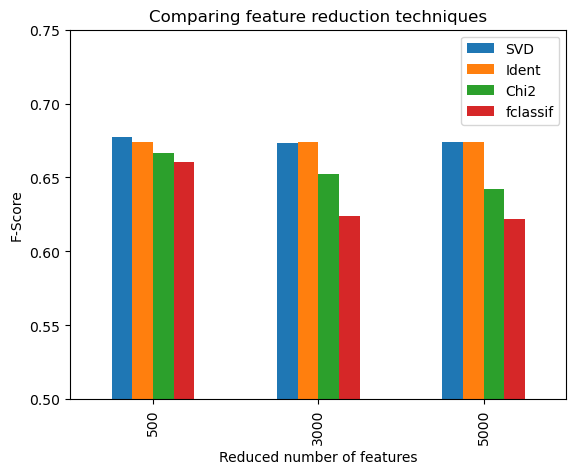

In [43]:
# select score for best C
#mean_scores = mean_scores.max(axis=0)
new_mean_scores_f = new_mean_scores.max(axis=1)
# create a dataframe to ease plotting
mean_scores_df = pd.DataFrame(
    new_mean_scores_f.T, index=N_FEATURES_OPTIONS, columns=reducer_labels
)

ax = mean_scores_df.plot.bar()
ax.set_title("Comparing feature reduction techniques")
ax.set_xlabel("Reduced number of features")
ax.set_ylim([.5,.75])
ax.set_ylabel("F-Score")
#ax.set_ylim((0, 1))
ax.legend(loc="upper right")

#plt.show()

Discussion questions
-------------------------

1. Call all the features with variable values in `param_gride` **grid features**. And call one particular
   assignment of values to **all** our grid features a **candidate** .  How many
   distinct candidate are there in our grid?
2. How many fittings did the grid search actually maker?  Note this depends 
   both on the number of candidates and the number of "folds". in the cross validation strategy.
3. Specifying a candidate by a complete assignment of gride features, whicg candidates are in out plot? Which have been left out of our plot? How do we know the omitted candidates might not be the best?
4. What is the best candidate?


Inclass exercise
-------------------

I had planned to end class with a much simpler grid construction exercise.  Using a Model A type architecture, construct a complete GridSearch CV system using the following feature dimensions

1.  chi2 vs fclassif, (optionally TruncatedSVD)
2.  3000, 5000, 1000 (number of features)
3.  C-value for the classifier (1, 10,100).

That's a total of 18 candidates. However, because Trincated SVD has been left out, this will run fairly quickly and give you a result.  If you're willing to try this out, I will stick around and help you debug your code, as well as interpret the results (which is perhaps the hardest part).  

If you'd rather not we can end class now.  No harm no foul.  In that case, I will begin class next week with this exercise.

## Notebook content ends here

## Plot of an earlier simpler system

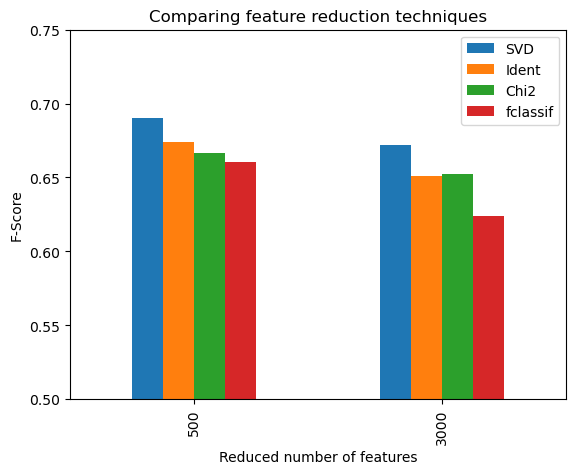

In [28]:
# select score for best C
#mean_scores = mean_scores.max(axis=0)
new_mean_scores_f = new_mean_scores.max(axis=1)
# create a dataframe to ease plotting
mean_scores_df = pd.DataFrame(
    new_mean_scores_f.T, index=N_FEATURES_OPTIONS, columns=reducer_labels
)

ax = mean_scores_df.plot.bar()
ax.set_title("Comparing feature reduction techniques")
ax.set_xlabel("Reduced number of features")
ax.set_ylim([.5,.75])
ax.set_ylabel("F-Score")
#ax.set_ylim((0, 1))
ax.legend(loc="upper right")

#plt.show()